# Partial least squares - discriminant analysis

As before, switch to the right kernel by clicking on the button in the top 
right corner with "Python 3 (ipykernel)" and switch to "omics_predoc_course".

Wikipedia has a nice explanation of the theory behind partial least squares (PLS) 
method and the related partial least squares discriminant analysis (PLS-DA) 
[here](https://en.wikipedia.org/wiki/Partial_least_squares_regression).

This method was chosen as it can help us relate the minimum inhibitory 
concentration (MIC) values with the expression counts and find genes 
potentially responsible for antibiotic resistance.

As in the previous notebook, we first load the packages needed in this notebook.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from enrichment import get_ora
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score


sns.set_theme()


def separate(data, col, into, sep="_", **kwargs):
    return data.assign(
        **data.get(col).str.split(sep, expand=True, **kwargs)
        .rename(columns={i: x for i, x in enumerate(into)})
    )

## Load the data

We load the normalised counts from DESeq2 analysis:

In [2]:
df_norm = pd.read_csv("../Output/DESeq2/normalised_counts.csv", index_col=0)

We also load the MIC values and we create additional columns for level of 
antibiotic resistence for both antibiotics (0 for low ABR and 1 for high ABR):

In [3]:
mic_threshold = 30
df_mic = (
    pd.read_csv("../Data/mic.csv", dtype={"strain": str})
    .assign(
        cza_mic_level=lambda x: (x.cza_mic > mic_threshold).astype(int),
        mem_mic_level=lambda x: (x.mem_mic > mic_threshold).astype(int)
    )
)

We can plot the MIC values like below:

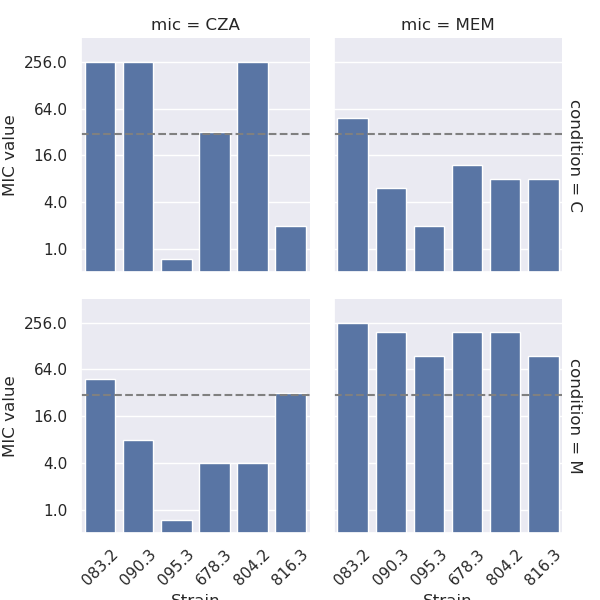

In [4]:
# Convert mic table to long format
df_mic_long = (
    df_mic.melt(
        id_vars=["strain", "condition"], 
        value_vars=["cza_mic", "mem_mic"], 
        var_name="mic", 
        value_name="mic_value"
    )
    .assign(mic=lambda x: x.mic.str.removesuffix("_mic").str.upper())
)

# Make the plot with seaborn FacetGrid
g = (
    sns.FacetGrid(
        df_mic_long.query("condition != 'P'"), 
        col="mic", 
        row="condition",
        margin_titles=True
    )
    .map_dataframe(sns.barplot, x="strain", y="mic_value")
    .set(ylabel="MIC value", xlabel="Strain")
    .refline(y=mic_threshold)
)

# Changes to log2 scale for y-axis
yticks = 2.0**np.arange(0, 10, 2)
for ax in g.axes.flatten():
    ax.set_yscale("log", base=2)
    ax.tick_params(axis="x", labelrotation=45)
    ax.set(yticks=yticks, yticklabels=yticks, ylim=(0.5, 2**9))

## Create the model

To create the PLS-DA model, we first need to transform the dataframe such that the each gene is a feature in the model:

In [5]:
df_norm_rot = (
    df_norm
    .transpose()
    .reset_index(names="sample")
    .pipe(separate, "sample", ["strain", "condition", "replicate"], sep="_")
    .merge(df_mic, on=["strain", "condition"], how="left")
)
df_norm_rot.head()

,sample,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,...,PA5568,PA5569,PA5570,strain,condition,replicate,cza_mic,mem_mic,cza_mic_level,mem_mic_level
0,083.2_C_A,5220.732964,6296.697977,6468.349983,16989.361962,588.919891,271.433457,151.416607,2340.328570,2359.168424,...,8388.619579,7076.109728,1159.697699,083.2,C,A,256.0,48.0,1,1
1,083.2_C_B,5995.205109,7725.134664,8212.623565,21378.861047,592.455454,289.667318,131.208193,2420.286507,2457.630377,...,10018.250154,7662.558449,629.799325,083.2,C,B,256.0,48.0,1,1
2,083.2_C_C,9486.768364,11275.401217,12061.581343,29299.092068,628.359581,244.037325,135.901026,2829.079414,3368.299612,...,14877.509045,9345.022133,416.470885,083.2,C,C,256.0,48.0,1,1
3,083.2_M_A,7606.620910,8759.406768,11216.328926,24165.620400,839.994947,292.610852,134.954143,2504.849797,2975.297418,...,11661.551473,9078.503948,567.564153,083.2,M,A,48.0,256.0,1,1
4,083.2_M_B,6496.149593,8039.748776,10054.776996,22424.952765,813.546007,281.024653,123.202837,2218.669273,2824.501406,...,12805.967623,9338.978694,584.449822,083.2,M,B,48.0,256.0,1,1


We get columns with features (genes) and the target variable (mic values for one antibiotic) from the above table:

In [6]:
meta_cols = ["sample", "strain", "condition", "replicate", "cza_mic", "mem_mic", "cza_mic_level", "mem_mic_level"]

x = df_norm_rot.drop(columns=meta_cols).to_numpy()
y = df_norm_rot.mem_mic_level.to_numpy()

We create the PLS object and fit it to the data above:

In [7]:
pls = PLSRegression(n_components=2)
pls.fit(x, y)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


We can plot the factors values and see how samples separate depending on the MIC level values:

<Axes: xlabel='Factor1', ylabel='Factor2'>

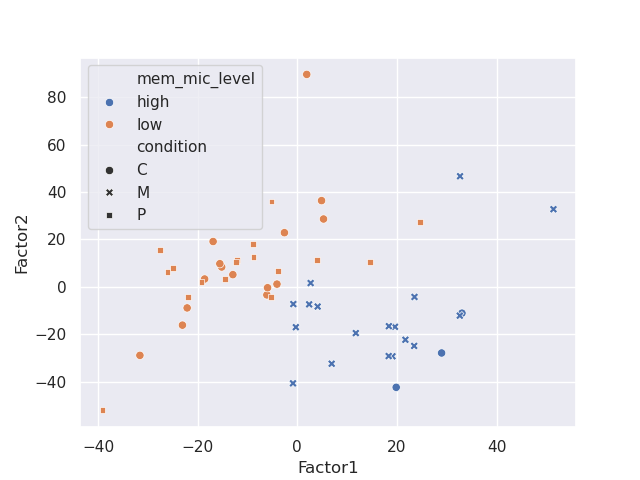

In [8]:
x_pls, y_pls = pls.transform(x, y)

df_pls = (
    pd.DataFrame(x_pls, columns=["Factor1", "Factor2"])
    .join(df_norm_rot.get(meta_cols))
)

fig, ax = plt.subplots()
sns.scatterplot(
    df_pls.replace({"mem_mic_level": {0: "low", 1: "high"}}), 
    x="Factor1",
    y="Factor2",
    style="condition", 
    hue="mem_mic_level",
    ax=ax
)

To calculate the accuracy of the model, we predict the MIC values and use `accuracy_score()` function from scikit-learn library:

In [9]:
y_pred = [1 if y > 0.5 else 0 for y in pls.predict(x)]
accuracy_score(y, y_pred)

0.9074074074074074

In [10]:
df_loadings = (
    pd.DataFrame(pls.x_loadings_, columns=["PLS1", "PLS2"])
    .assign(feature=df_norm_rot.drop(columns=meta_cols).columns)
)

**Tasks:** 
- can you determine what the top features have in common for this model?
- try to fit the other antibiotic
- is the accuracy of this model reasonable? What could you do to check this?

If you have time, you can move on to the last notebook [04_plsda_extra](04_plsda_extra.ipynb).